In [1]:
# import packages 
import awkward as ak
import pandas as pd
import numpy as np
import re
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Import DMRs for all comparisons 

In [2]:


def read_methylscore(input_file)->ak.Array:
    """Read the filtered output methylscore into an akward array"""
    # Reading data from the input file and converting it to an awkward array
    array = []
    with open(input_file, 'r') as file:
        for line in file:
            columns = line.strip().split('\t')  # Split the line into columns
            array.append(columns)
    return ak.from_iter(array)

In [3]:
# Dictionary to store dmr_subset with their names
dmr_subsets = {}

# create an input file dict 
input_files = {'NvsA': '6_DMRsCG/1_NvsA/1_NvsA.txt', 'NvsR': '6_DMRsCG/2_NvsR/2_NvsR.txt', 'AvsR': '6_DMRsCG/3_AvsR/3_AvsR.txt'}


# Process each input file
for input_file in input_files.values():
    df = read_methylscore(input_file)

    # Extract column 1, 2, 3
    dmr_subset = df[:, [0, 1, 2]]

    # Convert to pandas dataframe
    dmr_subset = pd.DataFrame(dmr_subset)
    dmr_subset.rename(columns={0: 'chr', 1: 'start', 2: 'end'}, inplace=True)

    # Convert to int
    dmr_subset['start'] = dmr_subset['start'].astype(int)
    dmr_subset['end'] = dmr_subset['end'].astype(int)
    dmr_subset['chr'] = dmr_subset['chr'].astype(str)

    # Assign the name to dmr_subset
    subset_name = os.path.basename(os.path.dirname(input_file)).split('_')[-1] 
    dmr_subsets[subset_name] = dmr_subset


# 2) Import gene annotation

In [4]:
# import ccar_annotation.gtf as pd df 
import pandas as pd 

annotation = pd.read_csv('7_match_dmr_to_gene/ccar_annotation.gtf', sep='\t', skiprows=1, header=None)
# renaming the header of the annotation file
annotation = annotation.rename({0: 'seqname',
                                1: 'source',
                                2: 'feature',
                                3: 'start',
                                4: 'stop',
                                5: 'score',
                                6: 'strand',
                                7: 'frame',
                                8: 'attribute'}, axis=1)

    
# define a function to extract the geneid
def extract_gene_id(attributes):
    # Using a regular expression to match and extract the desired part
    match = re.search(r'gene_id "([^"]+)"', attributes)
    if match:
        return match.group(1)
    else:
        return 0 # Return 0 if there is no match
    
# filtering the column feature for transcritps
annotation = annotation[annotation['feature'] == 'transcript']

# Apply the function to the "attributes" column and create a new column with the extracted gene ids
annotation['gene_id'] = annotation['attribute'].apply(extract_gene_id)

# DEDUPLICATE 
# since a gene has multiple transcripts you have to deduplicate the geneids 
# calculate trascript length 
annotation['length'] = annotation['stop'] - annotation['start']
# sort annotation for geneid and transcript length (length is sorted ascending) 
annotation = annotation.sort_values(['gene_id','length'])
# deduplicate to keep the gene id with the longest transcript length 
annotation = annotation.drop_duplicates(subset=['gene_id'], keep='last')

# 3) Add 2000 bp to start and stop of gene id's to simulate UTRs (untranslated regions) 

In [5]:
# extract seqname , start and stop column 
annotation = annotation[['seqname', 'start', 'stop', 'gene_id']]
# create new column called "start_2000" (decrease the start value about 2000 bp to include promotor sequences)
annotation['start_2000'] = annotation['start'] - 2000
# check if any value is negative and replace it with 0
annotation['start_2000'] = np.where(annotation['start_2000'] < 0, 0, annotation['start_2000'])
# create new column called "stop_2000" (increase the stop value by 2000 bp to include ploy a tales)
annotation['stop_2000'] = annotation['stop'] + 2000

# 4) Identify if DMR is within gene borders --> append geneid to list 

In [6]:

# define function to append relevant information to dmrs
def append_info(dmr_df:pd.DataFrame, index:int, annotation:pd.DataFrame, list_to_append:list)->None:
    """Append relevant information of one row to the list_to_append.
    
    Parameters:
    -----------
    dmr_df: pd.DataFrame
        The dataframe containing the DMRs.
    index: int
        The index of the DMR to append.
    annotation: pd.DataFrame
        The dataframe containing the relvant line of the annotation."""
    line = pd.DataFrame(dmr_df.loc[index]).T            
    line['gene_id'] = annotation['gene_id'].values[0]
    line['start_2000'] = annotation['start_2000'].values[0]
    line['stop_2000'] = annotation['stop_2000'].values[0]
    list_to_append.append(line)


dmr_withinGeneBorder = {}

for subset_name, dmr_subset in dmr_subsets.items():
    temp = [] # list if dmrs hit more than 1 gene id 
    for index, row in dmr_subset.iterrows():
        relevant_annotation = annotation[(annotation['seqname'] == row['chr']) & (annotation['start_2000'] <= row['start']) & (annotation['stop_2000'] >= row['end'])]
        if len(relevant_annotation) == 1:
            append_info(dmr_subset, index, relevant_annotation, temp)
        elif len(relevant_annotation) > 1: # if a dmr hits more gene ids 
            for i,line in relevant_annotation.iterrows():
                append_info(dmr_subset, index, pd.DataFrame(line).T, temp)
    dmr_withinGeneBorder[subset_name] = pd.concat(temp)

In [7]:
# select unique geneids from the dmr_withinGeneBorder output
geneid_unique = {}
for name,df in dmr_withinGeneBorder.items():
    geneid_unique[name] = df['gene_id'].unique()


In [8]:
# check how many dmrs are within gene borders. 
number_of_transcripts = {}
for name, df in geneid_unique.items():
    number_of_transcripts[name] = len(df)
    print(name, number_of_transcripts[name])


NvsA 35
NvsR 58
AvsR 22


# 5) PLOT - Barplot (number of dmr within genes)

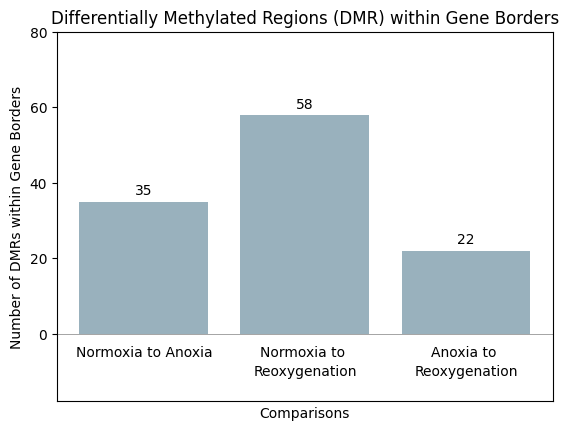

In [9]:
# PLOT
# Sample data
categories = number_of_transcripts.keys()
values = number_of_transcripts.values()

# Create a bar plot
plt.bar(categories, values, color='skyblue')
plt.title("Differentially Methylated Regions (DMR) within Gene Borders")
plt.xlabel("Comparisons")
plt.ylabel("Number of DMRs within Gene Borders")

# Add labels to the bars
for i, value in enumerate(values):
    plt.text(i, value + 1, str(abs(value)), ha='center', va='bottom', color='black')

# change the color of the bars (first two: blue, second two: red, third two: green)
plt.bar(range(len(number_of_transcripts)), list(number_of_transcripts.values()), align='center', color='#99B1BD')

# y scale 
plt.ylim(-18, 80)
# remove x scale
plt.xticks([])

# add a label in the center of the first two bars 
plt.text(0, -5, 'Normoxia to Anoxia', ha='center', va='center', color='black')
plt.text(1, -5, 'Normoxia to ', ha='center', va='center', color='black')
plt.text(1, -10, 'Reoxygenation', ha='center', va='center', color='black')
plt.text(2, -5, 'Anoxia to ', ha='center', va='center', color='black')
plt.text(2, -10, 'Reoxygenation', ha='center', va='center', color='black')

# add a 0 line 
# the line should be slim and grey
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)

# Save the figure as a high-quality image (e.g., PNG or PDF)
plt.savefig('7_match_dmr_to_gene/DMR_within_geneborders.png', format='png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


# 6) Correlate to DEGs

In [10]:
# import deg data from RNA pipeline 
deg_NvsA = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_na.txt', sep=',')
deg_NvsR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_nr.txt', sep=',')	
deg_AvsR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_ar.txt', sep=',')
# select gene id column 
deg_na = set(deg_NvsA['Unnamed: 0'])
deg_nr = set(deg_NvsR['Unnamed: 0'])
deg_ar = set(deg_AvsR['Unnamed: 0'])

print(len(deg_na))
print(len(deg_nr))
print(len(deg_ar))

1283
572
457


In [11]:
# Correlation of DEG and DMR 
correlationNA = pd.DataFrame(deg_na.intersection(geneid_unique['NvsA']))
correlationNR = pd.DataFrame(deg_nr.intersection(geneid_unique['NvsR']))
correlationAR = pd.DataFrame(deg_ar.intersection(geneid_unique['AvsR']))

# 7) Venn diagram 

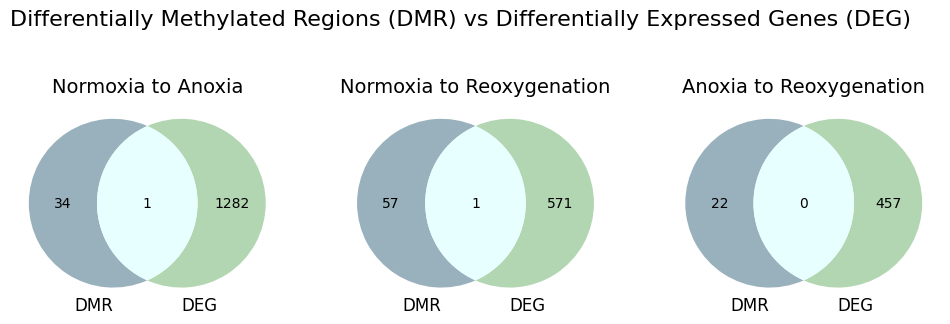

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted

# Sample data for Venn diagrams
# DMS data
DMR_na = set(geneid_unique['NvsA'])
DMR_nr = set(geneid_unique['NvsR'])
DMR_ar = set(geneid_unique['AvsR'])
# DEG data 
DEG_na = deg_na
DEG_nr = deg_nr
DEG_ar = deg_ar

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot Venn diagrams in each subplot
venn2_unweighted([DMR_na, DEG_na], set_labels=('DMR', 'DEG'), ax=axes[0], alpha=1, set_colors=('#99B1BD','#B2D6B1'), normalize_to=1.0)
venn2_unweighted([DMR_nr, DEG_nr], set_labels=('DMR', 'DEG'), ax=axes[1], alpha=1, set_colors=('#99B1BD','#B2D6B1'), normalize_to=1.0)
venn2_unweighted([DMR_ar, DEG_ar], set_labels=('DMR', 'DEG'), ax=axes[2], alpha=1, set_colors=('#99B1BD','#B2D6B1'), normalize_to=1.0)

# add titles to the subplots
axes[0].set_title('Normoxia to Anoxia', fontsize=14)
axes[1].set_title('Normoxia to Reoxygenation', fontsize=14)
axes[2].set_title('Anoxia to Reoxygenation', fontsize=14)

# Add titles in center 
fig.suptitle('Differentially Methylated Regions (DMR) vs Differentially Expressed Genes (DEG)', fontsize=16)

# Save the figure as a high-quality image (e.g., PNG or PDF)
plt.savefig('7_match_dmr_to_gene/DMR_vs_DEG_venn.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


# 8) DMR functional annotation 

In [13]:
# Import go terms and description 
# Geneid to GO term
goterm = pd.read_csv('9_DMR_functional_annotation/gene_id_goterms_df_fullgenome.tsv', sep='\t', header=None, names=['gene_id', 'goterm', 'chromosome'])

# GO term to description
godesc = pd.read_csv('9_DMR_functional_annotation/goterm_desc_ref.tsv', sep='\t', header=None, names=['biofunction', 'goterm', 'description'])

In [14]:
#create pandas series for gene_id and goterm
go_map = goterm.drop('chromosome', axis=1).set_index('gene_id', drop=True)['goterm']

# define a function to select the right go term for each gene id
def select(geneid): 
    temp = go_map.get(geneid,default=pd.Series())
    if isinstance(temp, pd.Series):
        return temp.tolist()
    else:
        return [temp]

# create empty dict
functional_annotation = {}

# append go term to dmr_withinGeneBorder
for name,df in dmr_withinGeneBorder.items():
    df = df.drop_duplicates(subset=['gene_id'])
    df['goterm'] = df['gene_id'].apply(select)
    
    df = df.explode('goterm').dropna(subset=['goterm'])
    df[['biofunction', 'description']] = godesc.set_index('goterm').loc[df ['goterm']].to_numpy()
    functional_annotation[name] = df.sort_values('biofunction')

/tmp/ipykernel_14824/832618622.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goterm'] = df['gene_id'].apply(select)
/tmp/ipykernel_14824/832618622.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goterm'] = df['gene_id'].apply(select)
/tmp/ipykernel_14824/832618622.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

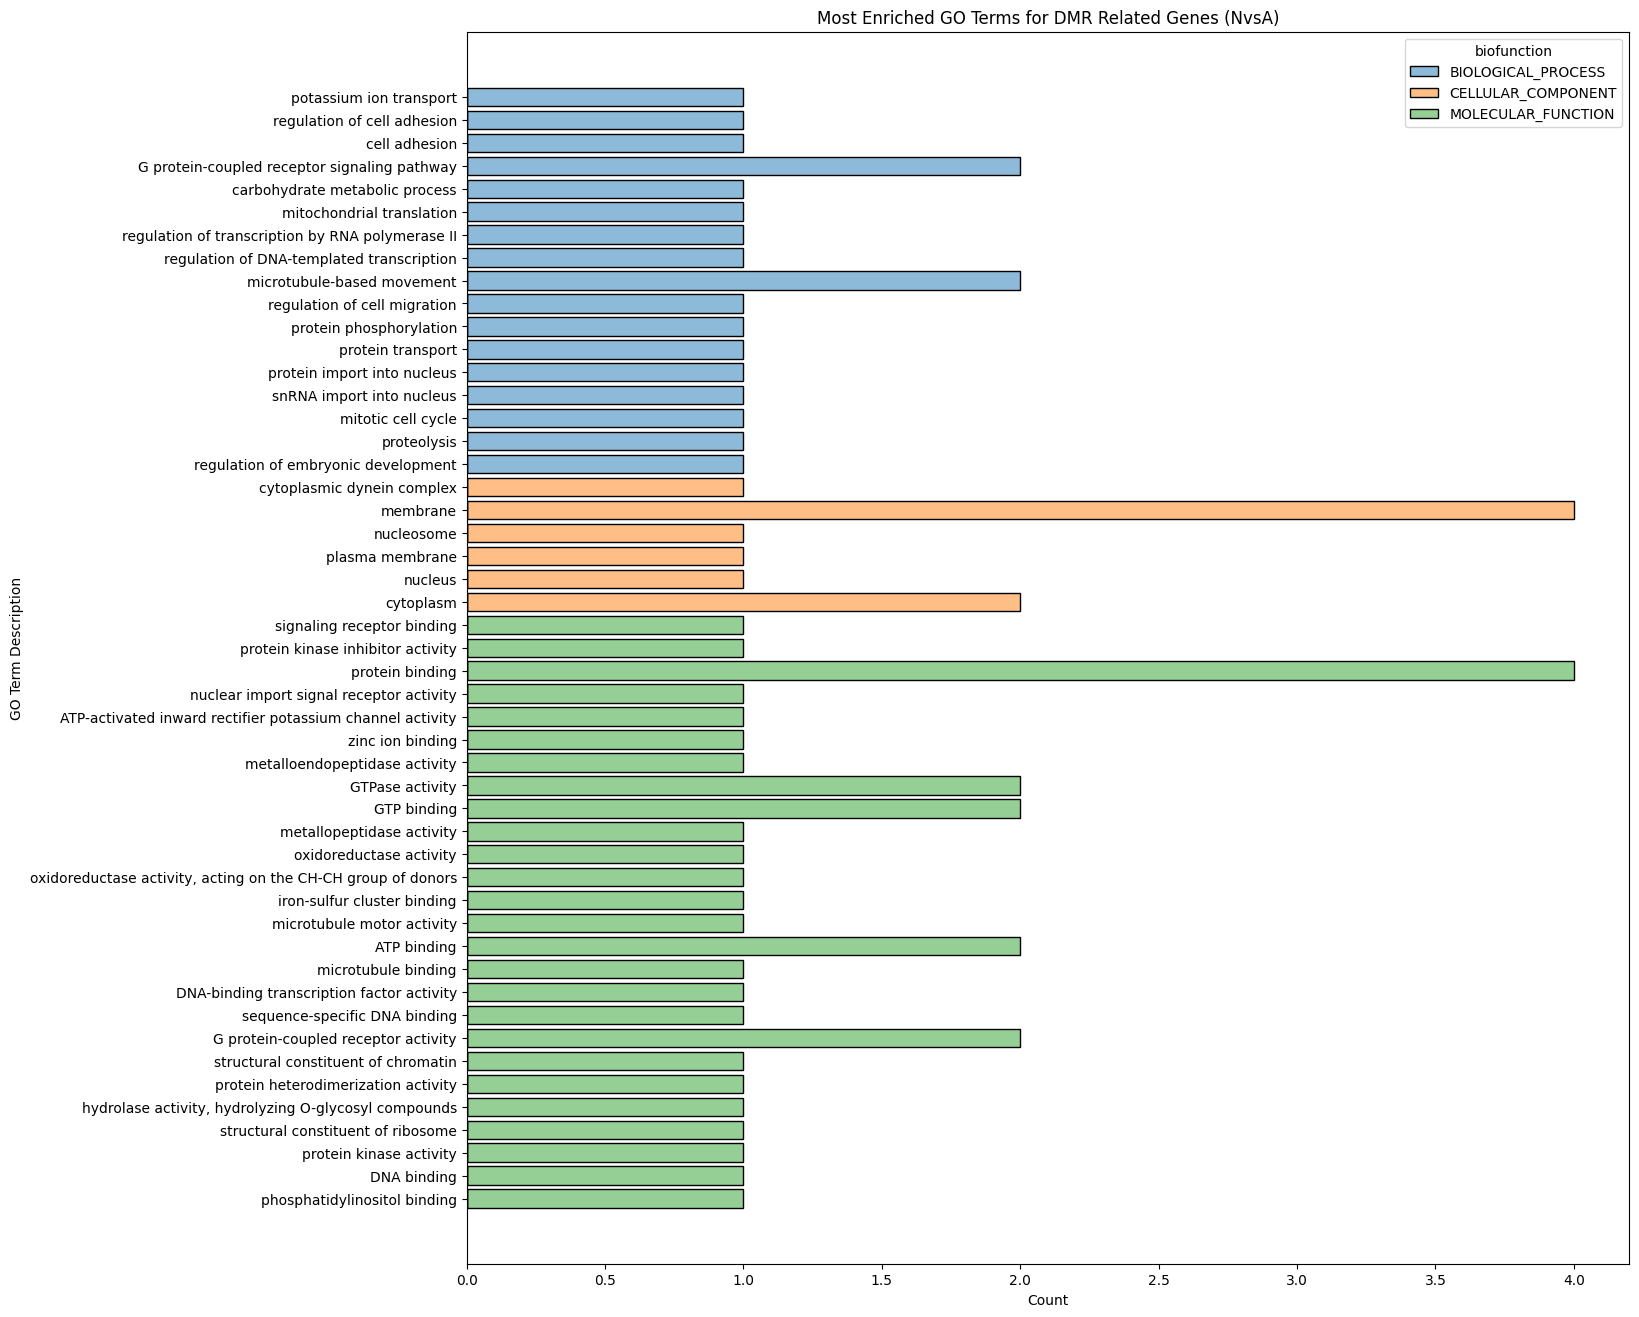

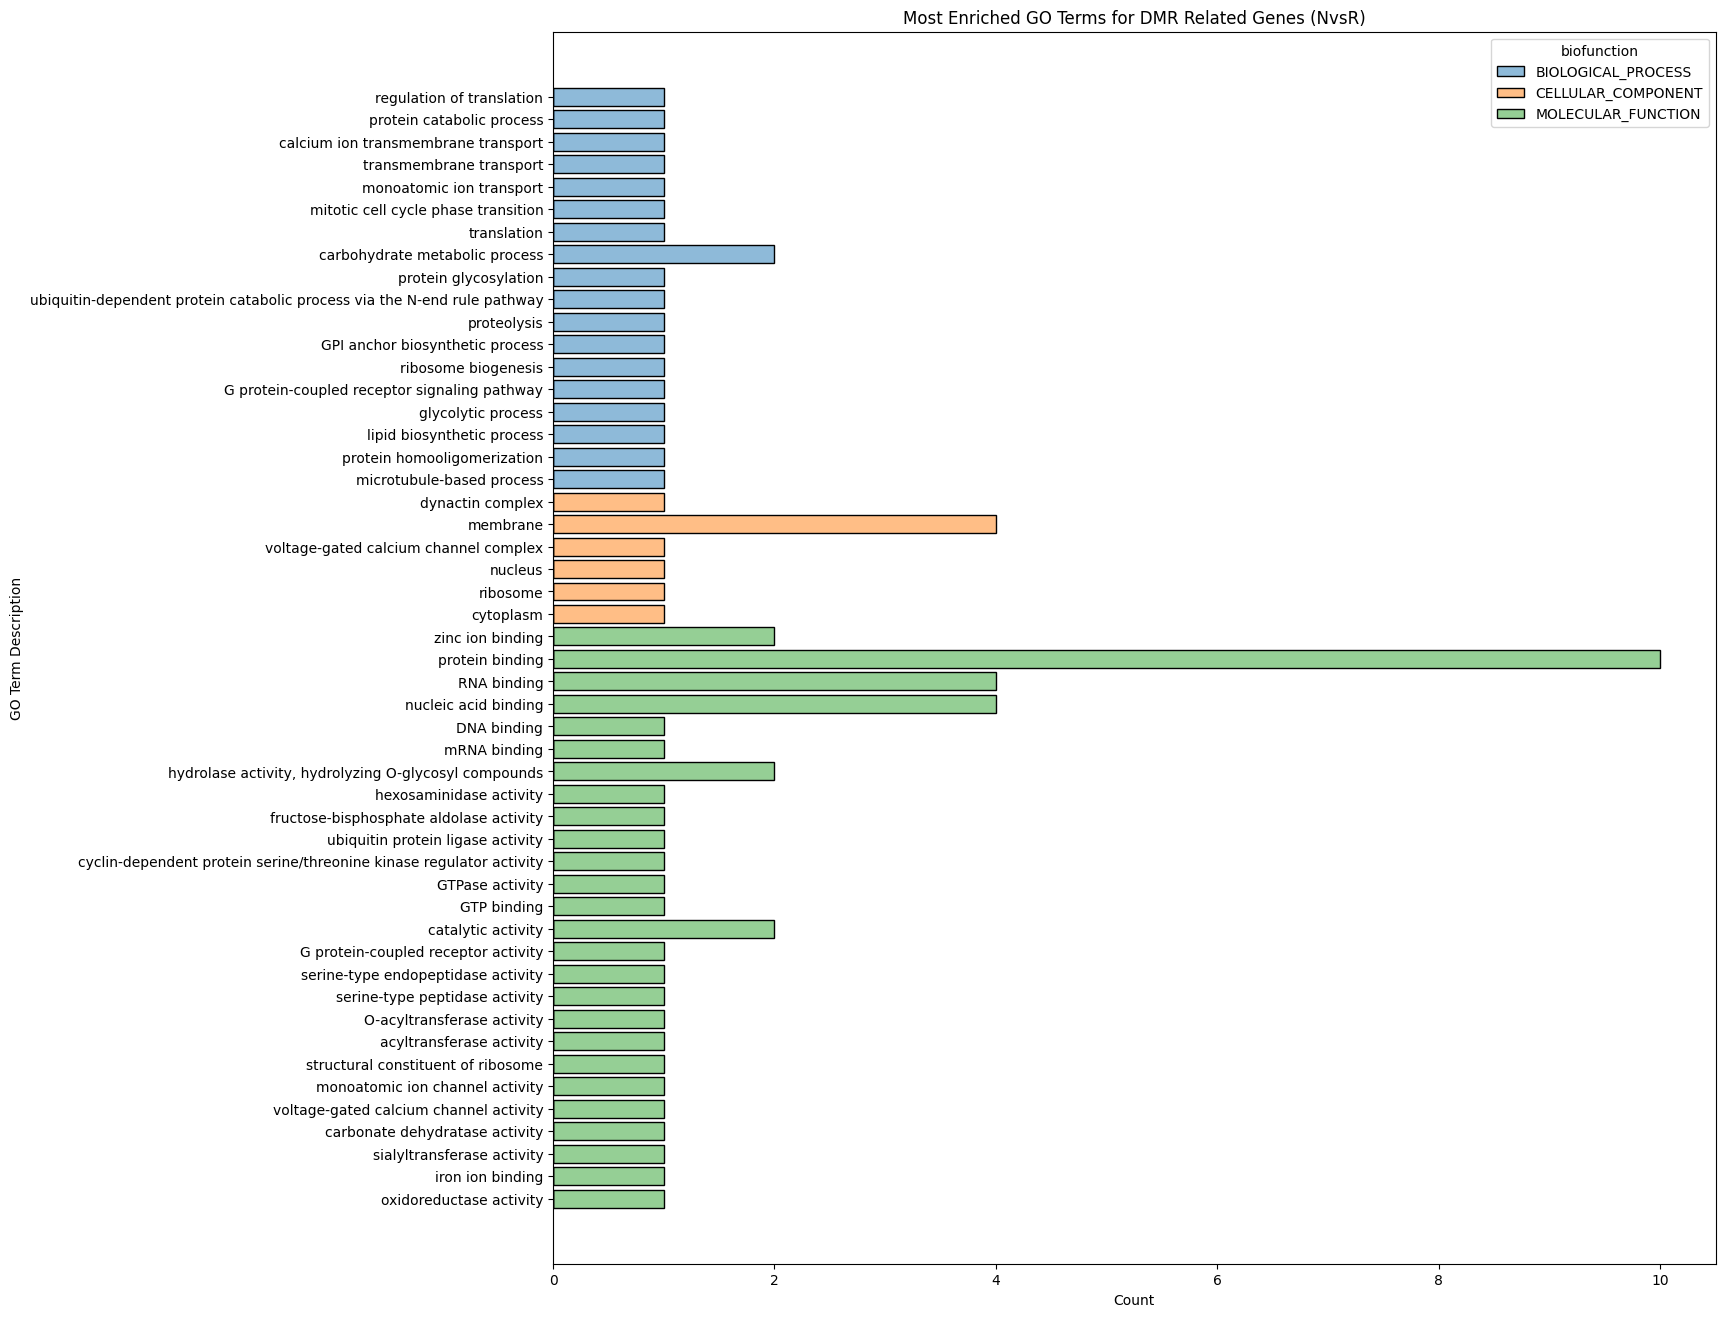

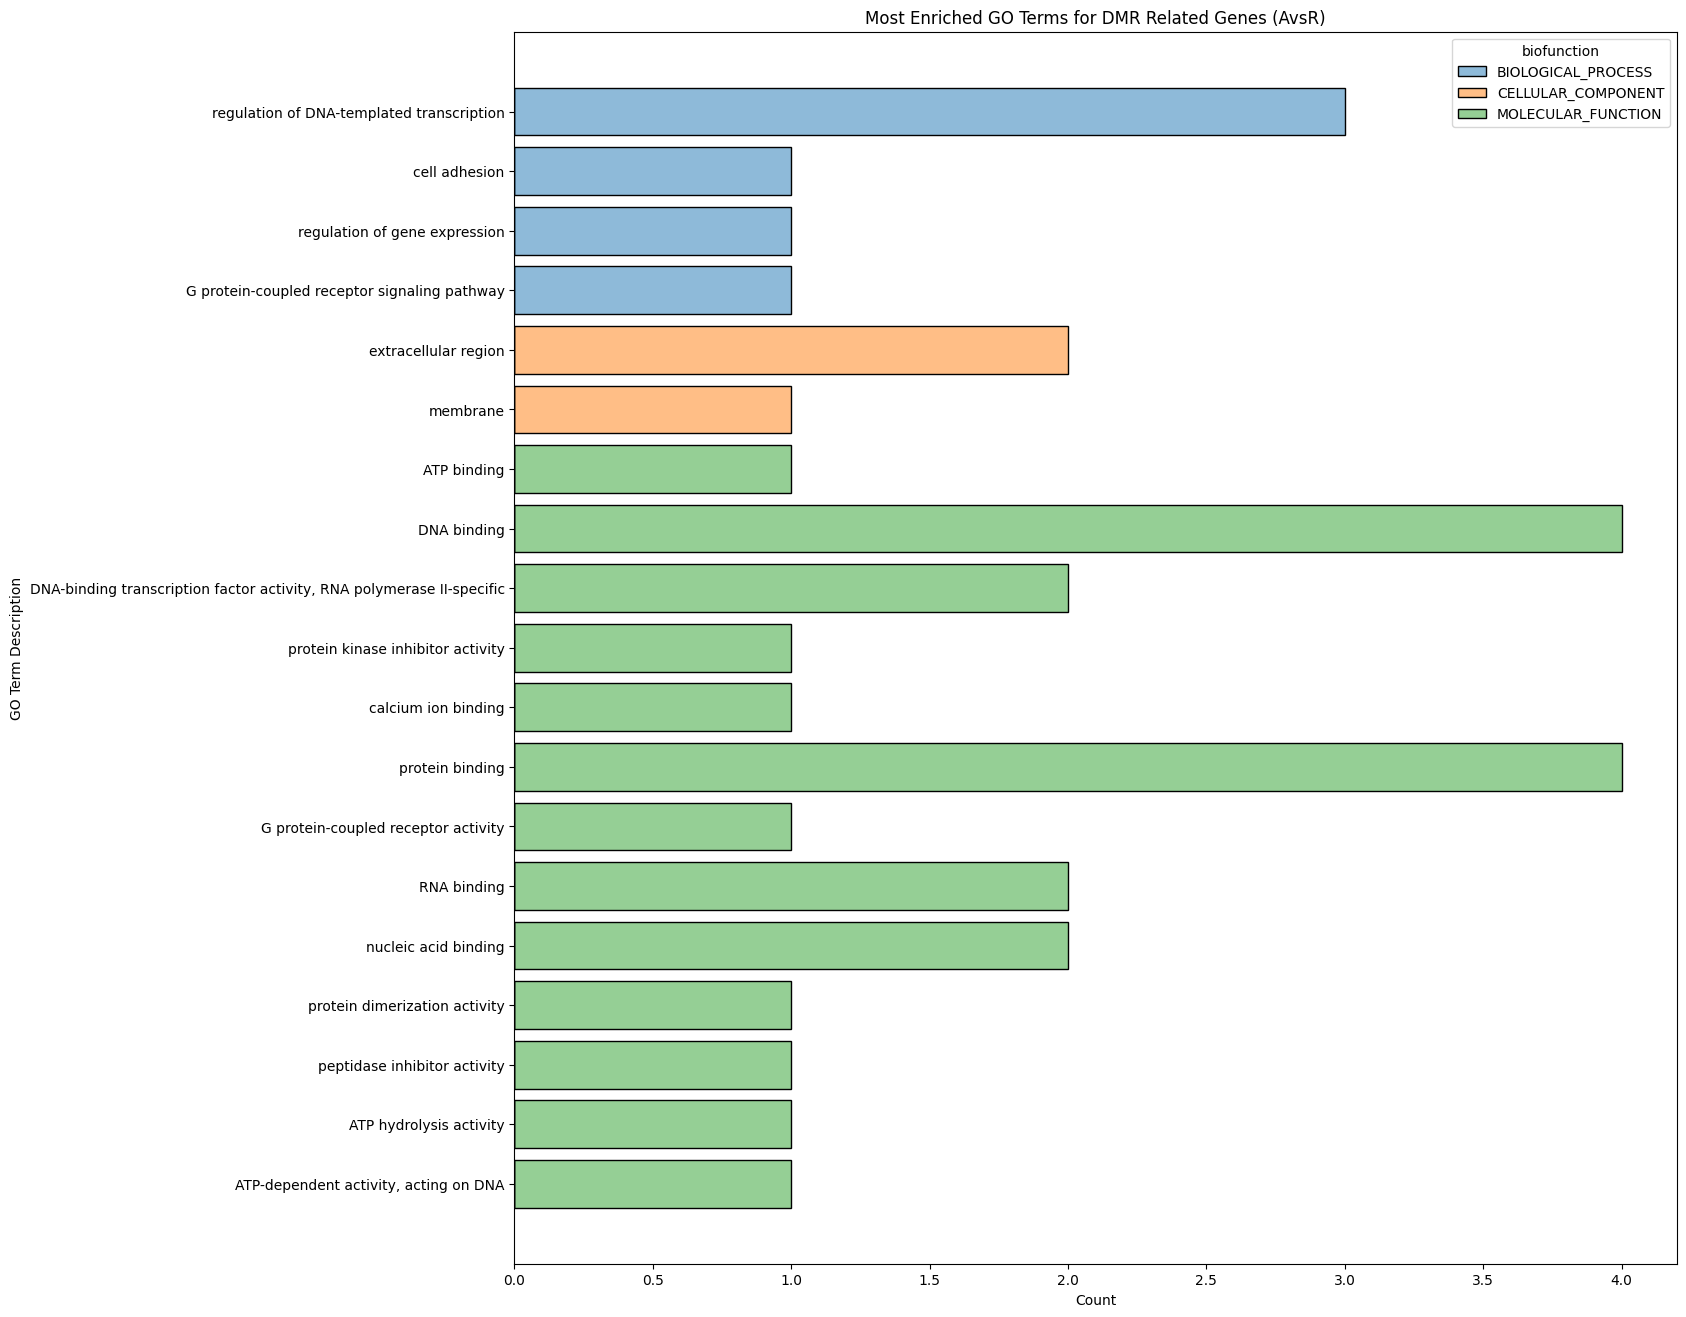

In [16]:
#PLOT
#create histogram 
for name, df in functional_annotation.items():
    fig,ax = plt.subplots(figsize=(15, 16))
    sns.histplot(data=df, y='description', hue='biofunction', shrink=0.8, discrete=True)
    plt.title(f'Most Enriched GO Terms for DMR Related Genes ({name})')
    plt.ylabel('GO Term Description')
    plt.savefig(f'7_match_dmr_to_gene/GO_terms_{name}.png', dpi=500, bbox_inches='tight')

# 9) investigate hyper- and hypomethlyation

In [17]:
# filter the input dmr files to only keep the dmrs that are within gene border 
# create dict 
select = {}

for name, df in dmr_withinGeneBorder.items():
    select[name] = df.index.unique().tolist()
    
import json 
with open ('7_match_dmr_to_gene/select_lines.json', 'w') as file:
    json.dump(select, file)

In [20]:


for name, input_file in input_files.items():
    # read inputfiles (function is defined above)
    array = read_methylscore(input_file)
    array = array[select[name]]
    with open (f'7_match_dmr_to_gene/dmr_withingene_{name}.txt', 'w') as file:
        for line in array:
            file.write('\t'.join(line) + '\n')




# 10) Investigate where DMR within gene 

In [21]:
dmr_withinGeneBorder['NvsA'].head(5)

,chr,start,end,gene_id,start_2000,stop_2000
0,ccar_ua01,7309102,7309279,ccar_ua01-ccar_g416,7297868,7315787
1,ccar_ua02,27087438,27087561,ccar_ua02-ccar_g4256,27085553,27093293
3,ccar_ua05,27251203,27251372,ccar_ua05-ccar_g10298,27229328,27255009
3,ccar_ua05,27251203,27251372,ccar_ua05-ccar_g10299,27249266,27253478
4,ccar_ua09,7433139,7433375,ccar_ua09-ccar_g15980,7416972,7450891


In [27]:
for name, df in dmr_withinGeneBorder.items():
    df['start_std'] = (df['start'] - df['start_2000']) / (df['stop_2000'] - df['start_2000'])
    df['end_std'] = (df['end'] - df['start_2000']) / (df['stop_2000'] - df['start_2000'])

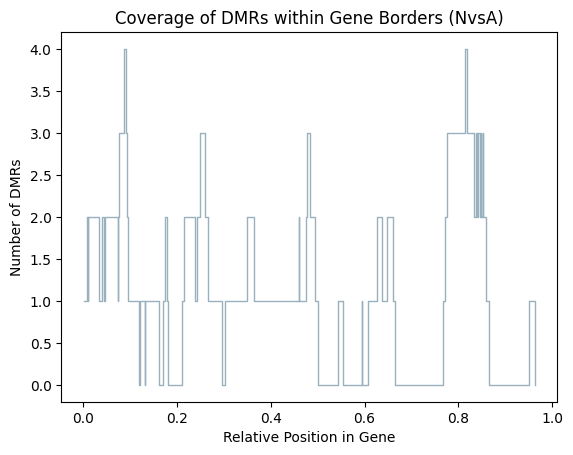

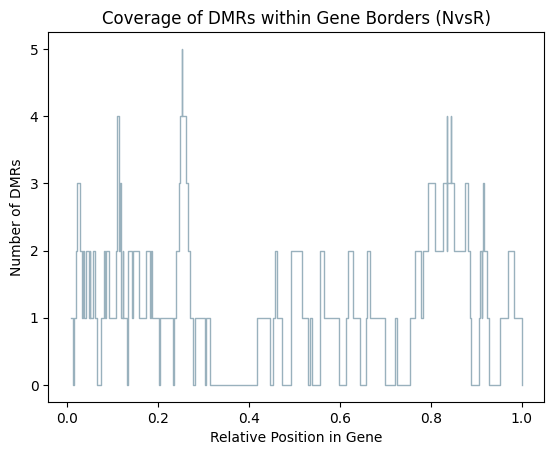

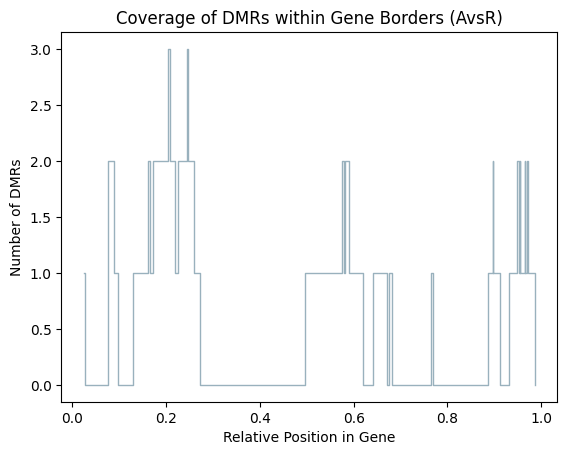

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


for name, df in dmr_withinGeneBorder.items():
    starts=pd.Series({i:1 for i in dmr_withinGeneBorder[name]['start_std']})
    stops =pd.Series({i:-1 for i in dmr_withinGeneBorder[name]['end_std']})
    all = pd.concat([starts, stops]).sort_index()
    all.index.name = 'position'
    coverage = all.groupby('position').sum().cumsum()
    plt.step(coverage.index, coverage, where='post', color='#99B1BD', linewidth=1)
    plt.title(f'Coverage of DMRs within Gene Borders ({name})')
    plt.xlabel('Relative Position in Gene')
    plt.ylabel('Number of DMRs')
    plt.savefig(f'7_match_dmr_to_gene/coverage_{name}.png', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()
    
 #plt.stairs
